<pre>
changelog of real files:
    * modified nodule_parser.py 'file_to_text' function to force utf-8 and ignore non-utf8 characters
    * passed 'label' column out of 'learner' as truth_marking (if vetting == True)
    
 nothing comitted - wait till review as i'm a n00b
</pre>


# setup everything

In [12]:
import nodule_parser
import nodule_learner
import nodule_extractor
import imp
imp.reload(nodule_parser)
imp.reload(nodule_learner)
imp.reload(nodule_extractor)
import pandas as pd
import json

import re
import numpy as np
import traceback
import warnings
import sys
from datetime import datetime
import os
from math import floor

from queue import Queue
from threading import Thread
import sqlite3

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

nl = nodule_learner.NoduleLearner(cache_size=500)

# Load data
Caveats:<br>
<ul>
    <li>only reads 1 level deep - make sure folder/file structure works</li>
    <li>only parses .txt files </li>
    <li>commented out code will limit parser to read the firs 20k files per dir</li>
</ul>

In [ ]:
import sqlite3
im
conn = sqlite3.Connection("predictions_20180725.sqlite")
patient_data = pd.read_sql("SELECT * FROM prediction", conn)
patient_data

In [14]:
# top = "../data-20180319/"

top = "../data-20180629/"

max_files_per_dir = 2  #read first 20k files per folder --- uncomend usage below if you need

## if Vetting => save to a sql db
vetting = True

if vetting: #stupid but wtvr
    conn = sqlite3.Connection("predictions_20180629.sqlite")
    b = pd.DataFrame([{'directory': '', 'filename': '', 'max_nodule_change': '', 'text':'',
     'max_nodule_location': '','max_nodule_lung': '', 'max_nodule_size': '', 'pid': '','is_nodule':'',
     'prediction': '','prev_max_date': '', 'probability': '', 'report_date': '','truth_marking': '', 'phrase_counter':'',
      'nodule_location':'', 'nodule_lung':'', 'nodule_phrase':'','nodule_size_numeric':'','evidence': '', 'nodule_size':''}])
    b.to_sql("prediction", conn, if_exists='append', chunksize=1000)

predictions = []
start_time = datetime.now()
# for folder in os.listdir(top)[2:4]:
for folder in os.listdir(top):
    counter = 0
    print("reading in data from %s" % folder)
    for file in sorted(os.listdir(top + folder)):
        if file.endswith(".txt"):
            try:
                if vetting:
                    prediction = pd.DataFrame( json.loads(
                        nl.transform_predict(
                            file=top + folder + "/" + file,
                            probability=True,
                            vetting=vetting)) )
                    prediction.to_sql("prediction", conn, if_exists='append', chunksize=1000)
                else:
                    predictions += json.loads(
                        nl.transform_predict(
                            file=top + folder + "/" + file,
                            probability=True,
                            vetting=vetting))
            except Exception as e:
                print("error with '%s/%s' -- %s" %(folder,file, e ))
            if counter % 2000 == 0: #print out a filename every 2k files
                print( "    "+file )
#             if counter >= max_files_per_dir: #read first 20k files per folder
#                 break
            counter += 1
            
if vetting:
    prediction = pd.DataFrame( json.loads(
        nl.transform_predict(
            file=top + folder + "/" + file,
            probability=True,
            vetting=vetting)) )
    prediction.to_sql("prediction", conn, if_exists='append', chunksize=1000)
else:
    predictions += json.loads(
        nl.transform_predict(
            file=top + folder + "/" + file,
            probability=True,
            vetting=vetting))
        
predictions_df = pd.DataFrame(predictions)
print(len(predictions_df))
print((datetime.now() - start_time).seconds)
predictions_df.head()


reading in data from phHealth
    ORU_ex1.txt
    Q334765116T338294334_20180219214129358.txt
    Q335243416T338774458_20180222010026542.txt
    Q335894249T339427946_20180226200613497.txt
    Q336445727T339983089_20180301175130838.txt
    Q337195881T340735745_20180306144114658.txt
    Q337903950T341446282_20180309210453539.txt
    Q338602883T342147628_20180314141322983.txt
    Q339258720T342805542_20180318150453667.txt
    Q339890149T343439051_20180321203332533.txt
    Q340609601T344160906_20180326161904293.txt
    Q341259275T344812636_20180329162148787.txt
    Q341958245T345514960_20180403141511716.txt
    Q342480407T346038907_20180405200231541.txt
    Q343776916T347338046_20180410175241477.txt
    Q345529319T349092329_20180413170453411.txt
    Q347618985T351184962_20180418132555473.txt
    Q348246158T351815713_20180421163158400.txt
    Q349080757T352653077_20180426132129948.txt
    Q350079084T353653936_20180501151718333.txt
    Q350728531T354305484_20180504160537049.txt
    Q351371727

""


# number of records, unique patients, and vetted records (per dir)

In [4]:
predictions_df.to_csv("predictions_df.csv")

In [6]:


predictions_df['directory'] = predictions_df.directory.apply(lambda path: path.split("_")[-1])
predictions_df.groupby(['directory']).agg({'max_nodule_size':'count',
                                       'pid': lambda x: len(list(set(x)) ),
                                       'truth_marking': lambda vals : len([v for v in vals if v==1 or v ==0])}  )

,max_nodule_size,pid,truth_marking
directory,,,
CCF,607,578,607
Community,119733,14616,0
HCA,107,1,0
Haymed,59034,19753,43
MUSC,658,378,137
Riaco,972,819,0
phHealth,66301,21664,95
powerscribe,2260,1151,1975


# number of records and unique patients with nodule size (per dir)

In [7]:
predictions_df[predictions_df.max_nodule_size != 0].groupby(['directory'])\
    .agg({'max_nodule_size':'count',
         'pid': lambda x: len(list(set(x)) ) }  )

,max_nodule_size,pid
directory,,
CCF,582,554
Community,570,425
Haymed,1234,863
MUSC,449,267
Riaco,612,518
phHealth,1459,752
powerscribe,1799,908


# count of nodule locations by records and unique patients (per dir) 

In [8]:
predictions_df[predictions_df.max_nodule_location != ''].groupby(['directory'])\
    .agg({'max_nodule_location':'count',
         'pid': lambda x: len(list(set(x)) ) }  )

,max_nodule_location,pid
directory,,
CCF,256,250
Community,237,193
Haymed,567,417
MUSC,315,192
Riaco,258,220
phHealth,593,423
powerscribe,1005,520


In [9]:
# breakdown of location counts
predictions_df[predictions_df.max_nodule_location != ''].groupby(['directory','max_nodule_location'])\
    .agg({'filename':'count',
         'pid': lambda x: len(list(set(x)) ) }  )

filename  pid
directory   max_nodule_location               
CCF         left lower lobe            64   62
            left upper lobe            49   48
            lingula                     9    9
            right lower lobe           48   47
            right middle lobe          18   17
            right upper lobe           68   67
Community   left lower lobe            58   51
            left upper lobe            33   26
            lingula                     8    7
            right lower lobe           63   54
            right middle lobe          30   27
            right upper lobe           45   37
Haymed      left lower lobe           117  101
            left upper lobe           106   79
            lingula                    19   14
            right lower lobe          148  114
            right middle lobe          57   44
            right upper lobe          120   93
MUSC        left lower lobe            47   31
            left upper lobe            71   43
            lingula                    12    7
            right lower lobe           78   42
            right middle lobe          25   19
            right upper lobe           82   54
Riaco       left lower lobe            54   50
            left upper lobe            51   41
            lingula                     9    6
            right lower lobe           56   52
            right middle lobe          25   21
            right upper lobe           63   51
phHealth    left lower lobe           106   87
            left upper lobe           121   84
            lingula                    17   14
            right lower lobe          132  102
            right middle lobe          64   44
            right upper lobe          153  111
powerscribe left lower lobe           368  104
            left upper lobe           133   92
            lingula                    16   13
            right lower lobe          201  137
            right middle lobe          93   57
            right upper lobe          194  134

In [10]:
# number of 'Truth' rows
predictions_df[predictions_df.evidence !=""].shape

(21337, 13)

In [13]:
# count of patiants where growth was recorded and details
growth_huh = predictions_df[predictions_df.max_nodule_size > 0.0].groupby(['directory','pid'])\
    .agg( {'max_nodule_size': 'unique',
          } ).reset_index()
growth_huh['sizehuh'] =growth_huh.max_nodule_size.apply(lambda x : len(set(x) ))
growth_huh = growth_huh[growth_huh['sizehuh'] >1]
growth_huh

,directory,pid,max_nodule_size,sizehuh
130,CCF,00029744696,"[12.0, 8.0]",2
276,CCF,00056833447,"[9.0, 4.0]",2
544,CCF,00086559099,"[89.0, 9.0]",2
557,Community,M006819,"[21.0, 19.0]",2
562,Community,M009120,"[2.0, 11.0]",2
588,Community,M025845,"[27.0, 26.0]",2
602,Community,M033626,"[12.0, 20.0]",2
608,Community,M039107,"[18.0, 14.0]",2
615,Community,M045293,"[13.0, 23.0]",2
620,Community,M050233,"[4.0, 9.0]",2


In [15]:
# of patients with growth per source
growth_huh.groupby('directory').agg({'pid': lambda pat: len(list(set(pat))) })

,pid
directory,
CCF,3
Community,53
Haymed,140
MUSC,17
Riaco,7
phHealth,98
powerscribe,98


# number of patients with growth

In [16]:

growth_huh.shape

(416, 4)

# number of patients with history per directory/source

In [17]:
history_df = predictions_df
history_df['num_reportDate'] = history_df['report_date']
history_df = history_df.groupby(['directory','pid'])\
    .agg( {'num_reportDate': 'unique' ,
          'report_date': ['min', 'max'],
          } ).reset_index()
    
history_df['sizehuh'] =history_df.num_reportDate.unique.apply(lambda x : len(set(x) ))
history_df = history_df[history_df['sizehuh'] >1]
print("reports for patients on multiple days only for %s patients in phHealth " % len(history_df))
print("table below shows number of days those patients were seen")
display( history_df.sort_values(by='sizehuh', ascending=False) )

reports for patients on multiple days only for 25736 patients in phHealth 
table below shows number of days those patients were seen


directory                          pid  \
                                                  
56602     phHealth                    000885240   
13405    Community                      M333711   
7168     Community                      M168127   
53073     phHealth                    000538651   
51368     phHealth                    000507142   
7856     Community                      M192432   
16181       Haymed                      0108978   
3541     Community                      M070942   
21330       Haymed                      0172114   
9036     Community                      M232034   
26429       Haymed                      0258789   
38000     phHealth                    000315050   
18862       Haymed                      0137476   
16483       Haymed                      0111468   
47997     phHealth                    000449961   
39449     phHealth                    000325790   
47119     phHealth                    000435648   
5482     Community                      M121691   
41534     phHealth                    000343561   
5541     Community                      M123369   
10696    Community                      M282960   
13056    Community                      M330147   
22585       Haymed                      0191545   
51696     phHealth                    000512862   
13510    Community                      M334361   
4346     Community                      M091366   
17128       Haymed                      0117813   
56343     phHealth                    000872467   
13917    Community                      M335612   
5439     Community                      M120504   
...            ...                          ...   
25295       Haymed                      0236039   
25290       Haymed                      0235934   
25189       Haymed                      0234197   
25193       Haymed                      0234286   
25198       Haymed                      0234349   
25203       Haymed                      0234590   
25205       Haymed                      0234611   
25210       Haymed                      0234700   
25212       Haymed                      0234736   
25213       Haymed                      0234819   
25216       Haymed                      0234836   
25225       Haymed                      0235078   
25226       Haymed                      0235084   
25233       Haymed                      0235165   
25242       Haymed                      0235313   
25243       Haymed                      0235318   
25247       Haymed                      0235388   
25249       Haymed                      0235417   
25253       Haymed                      0235512   
25260       Haymed                      0235590   
25261       Haymed                      0235604   
25263       Haymed                      0235633   
25267       Haymed                      0235673   
25269       Haymed                      0235702   
25271       Haymed                      0235714   
25277       Haymed                      0235781   
25282       Haymed                      0235841   
25286       Haymed                      0235891   
25288       Haymed                      0235926   
58951  powerscribe  W00661415^^^SMG_MRN^SMG_MRN   

                                          num_reportDate report_date  \
                                                  unique         min   
56602  [20180315, 20180316, 20180317, 20180318, 20180...    20180315   
13405  [20180218, 20180219, 20180220, 20180221, 20180...    20171215   
7168   [20180201, 20171209, 20171210, 20171231, 20171...    20171201   
53073  [20180218, 20180219, 20180224, 20180225, 20180...    20180218   
51368  [20180307, 20180308, 20180309, 20180310, 20180...    20180307   
7856   [20171219, 20171229, 20171217, 20180102, 20180...    20171212   
16181  [20180111, 20180119, 20171109, 20171116, 20171...    20171109   
3541   [20171230, 20171130, 20171214, 20171218, 20171...    20171130   
21330  [20180109, 20180112, 20180303, 20180304, 20180...    20171129   
903

# calculate model accuracy and phrase accuracy
## records positively labeled
### truth_marking of 1 means there was a match on "qb_y" or "[lngnod]" or "afnrzga19b"
## records labeld as false
### truth_marking of 0 means there was a match on "qb_n"
### truth_marking of -1 for all other records with 'is_nodule', but no validation

In [18]:
predictions_df.truth_marking.value_counts()

-1    246815
 1      2852
 0         5
Name: truth_marking, dtype: int64

# Classification Reports

In [25]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

def print_model_performance(predictions_df, dir_name='All'):
    dict_of_vals = {}
    output_str = ""
    if dir_name:
        output_str += "Classification results for directory: {}\n\n".format(dir_name)
    if dir_name != 'All':
        predictions_df = predictions_df[(predictions_df.directory == dir_name)]
    marked_negative = predictions_df.query("truth_marking == 0")
    marked_positive = predictions_df.query('truth_marking == 1')
    unmarked = predictions_df.query('truth_marking == -1')
    vetted = predictions_df.query("truth_marking == 0 | truth_marking == 1")
    with_size = predictions_df.query("max_nodule_size > 0")
    with_location = predictions_df.query("max_nodule_location != ''")
    with_lung = predictions_df.query("max_nodule_lung != ''")
    with_growth = predictions_df.query("max_nodule_change != 0")
    predicted_negative = predictions_df.query("prediction == 0")
    predicted_positive = predictions_df.query("prediction == 1")
    dict_of_vals['Negative'] = len(marked_negative)
    dict_of_vals['Positive'] = len(marked_positive)
    dict_of_vals['Unmarked'] = len(unmarked)
    dict_of_vals['pred_negative'] = len(predicted_negative)
    dict_of_vals['pred_positave'] = len(predicted_positive)
    
    dict_of_vals['with_size'] = len(with_size)
    dict_of_vals['with_location'] = len(with_location)
    dict_of_vals['with_lung'] = len(with_lung)
    dict_of_vals['with_growth'] = len(with_growth)
    # output to string out
    output_str += "Number marked negative: {}\n".format(len(marked_negative))
    output_str += "Number marked positive: {}\n".format(len(marked_positive))
    output_str += "Number unmarked: {}\n".format(len(unmarked))
    
    output_str += "\nNumber predicted negative: {}\n".format(len(predicted_negative))
    output_str += "Number predicted positive: {}\n".format(len(predicted_positive))
    
    output_str += "\nNumber with size extracted: {}\n".format(len(with_size))
    output_str += "Number with location extracted: {}\n".format(len(with_location))
    output_str += "Number with lung (right/left) extracted: {}\n".format(len(with_lung))
    output_str += "Number with growth extracted: {}\n\n".format(len(with_growth))
    if len(marked_negative) > 0:
        output_str += "Percent predicted correctly when marked negative: {}\n".format(
            len(marked_negative.query("prediction == 0")) / len(marked_negative))
    if len(marked_positive) > 0:
        output_str += "Percent predicted correctly when marked positive: {}\n".format(
            len(marked_positive.query("prediction == 1")) / len(marked_positive))
    if len(unmarked) > 0:
        output_str += "Predictions when unmarked:\n{}\n".format(unmarked['prediction'].value_counts())
    if not vetted.empty:
        vetted = predictions_df.query("truth_marking == 0 | truth_marking == 1")
        output_str += "\nClassification Report based off of Vetted data\n"
        original_report = classification_report(vetted['prediction'], vetted['truth_marking'] )
        output_str += original_report
    output_str += "\n\n"
    print(output_str)    
    return output_str,dict_of_vals
output_str = ""
t_str,temp_dict=print_model_performance(predictions_df)
data_stats_dict = {'all':temp_dict}
output_str += t_str
for directory in predictions_df['directory'].unique():
    temp_str,temp_dict = print_model_performance(predictions_df, directory)
    data_stats_dict[directory] = temp_dict
    output_str += temp_str
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d")
filename = "model_performance_{}.txt".format(timestamp)
with open(filename, 'w') as f:
    f.write(output_str)
print("Created file {}".format(filename))

Classification results for directory: All

Number marked negative: 5
Number marked positive: 2852
Number unmarked: 246815

Number predicted negative: 213241
Number predicted positive: 36431

Number with size extracted: 6705
Number with location extracted: 3231
Number with lung (right/left) extracted: 3362
Number with growth extracted: 469

Percent predicted correctly when marked negative: 0.8
Percent predicted correctly when marked positive: 0.9929873772791024
Predictions when unmarked:
0    213217
1     33598
Name: prediction, dtype: int64

Classification Report based off of Vetted data
             precision    recall  f1-score   support

          0       0.80      0.17      0.28        24
          1       0.99      1.00      1.00      2833

avg / total       0.99      0.99      0.99      2857



Classification results for directory: Community

Number marked negative: 0
Number marked positive: 0
Number unmarked: 119733

Number predicted negative: 115647
Number predicted positive: 4

In [77]:
a.to_json()

'{"Negative":{"CCF":0,"Community":0,"HCA":0,"Haymed":0,"MUSC":0,"Riaco":0,"all":5,"phHealth":0,"powerscribe":5},"Positive":{"CCF":607,"Community":0,"HCA":0,"Haymed":43,"MUSC":137,"Riaco":0,"all":2852,"phHealth":95,"powerscribe":1970},"Unmarked":{"CCF":0,"Community":119733,"HCA":107,"Haymed":58991,"MUSC":521,"Riaco":972,"all":246815,"phHealth":66206,"powerscribe":285},"pred_negative":{"CCF":0,"Community":115647,"HCA":107,"Haymed":39931,"MUSC":112,"Riaco":0,"all":213241,"phHealth":57356,"powerscribe":88},"pred_positave":{"CCF":607,"Community":4086,"HCA":0,"Haymed":19103,"MUSC":546,"Riaco":972,"all":36431,"phHealth":8945,"powerscribe":2172},"with_growth":{"CCF":0,"Community":43,"HCA":0,"Haymed":105,"MUSC":22,"Riaco":8,"all":469,"phHealth":140,"powerscribe":151},"with_location":{"CCF":256,"Community":237,"HCA":0,"Haymed":567,"MUSC":315,"Riaco":258,"all":3231,"phHealth":593,"powerscribe":1005},"with_lung":{"CCF":277,"Community":242,"HCA":0,"Haymed":598,"MUSC":316,"Riaco":272,"all":3362,"phH

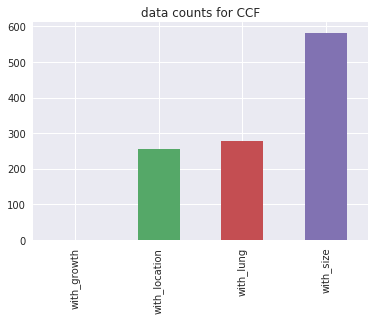

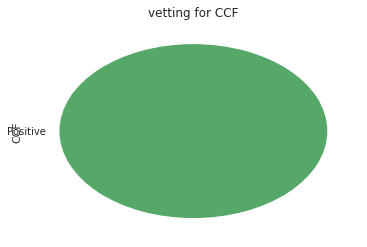

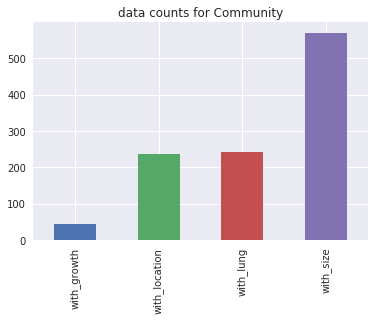

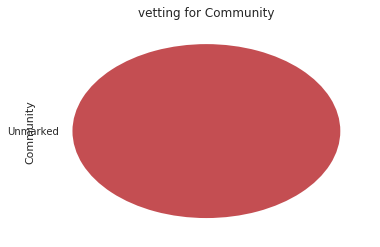

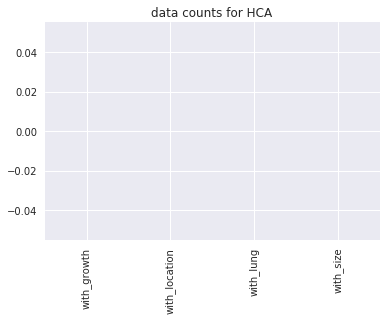

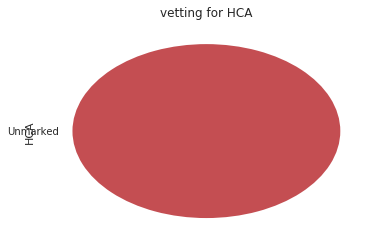

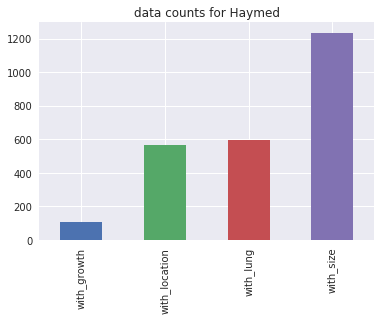

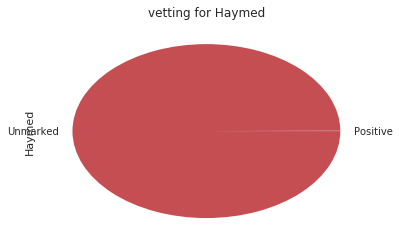

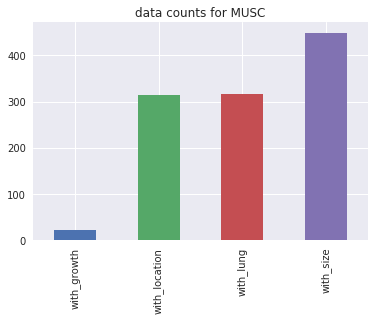

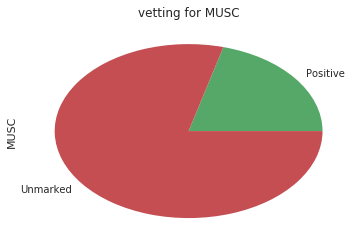

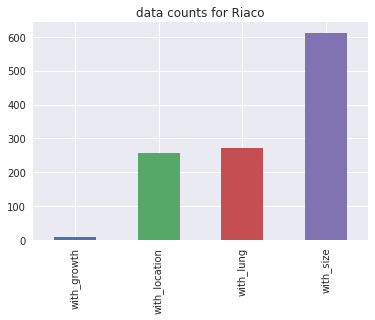

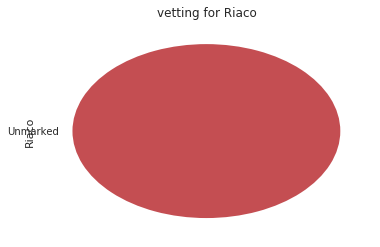

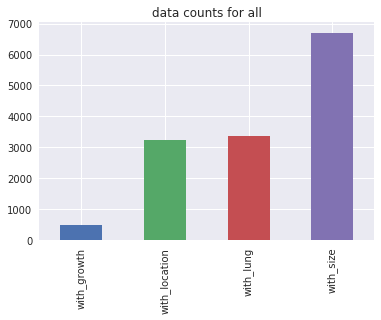

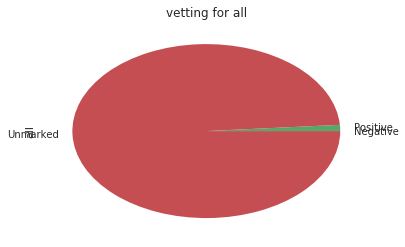

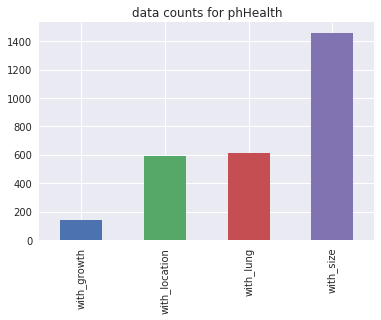

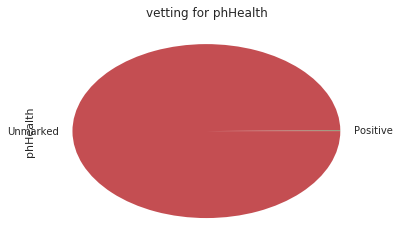

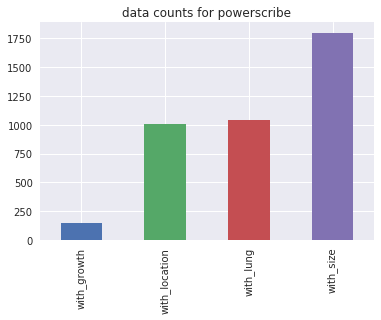

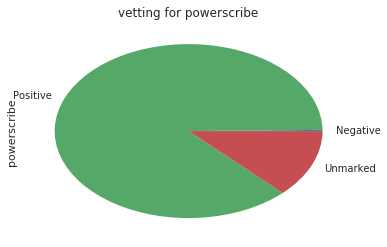

In [88]:
### make charts for each 'rating ###
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
a = pd.DataFrame(data_stats_dict).T
marked_columns = ['Negative','Positive', 'Unmarked']
predic_columns = ['pred_negative','pred_positave' ]
counts = ['with_growth','with_location', 'with_lung','with_size']
for i in a.index:
    a.loc[i][counts].plot(kind="bar",title="data counts for %s"% i)
    plt.show()
    
    a.loc[i][marked_columns].plot(kind="pie",title="vetting for %s"% i)
    plt.show()
    
#     plt.hist(a.loc[i][marked_columns], normed=True, alpha=0.5)
#     plt.hist(a.loc[i][predic_columns], normed=True, alpha=0.5)
#     plt.show()

In [26]:
import warnings
warnings.filterwarnings('ignore')
for di in predictions_df.directory.unique():
    try:
        temp_df = predictions_df[predictions_df.directory == di]
        if len(temp_df) == 0:
            print(" :( sorry no data to assess")
        else:
            print("calculating for %s " % di)
            temp_df.truth_marking = temp_df[~pd.isnull(temp_df.truth_marking) ]['truth_marking'].astype(int)
            print("Classification Report based off of Vetted data for DIRECTORY %s" % di)
            original_report = classification_report(temp_df[~pd.isnull(temp_df.truth_marking) ]['prediction'], 
                                    temp_df[~pd.isnull(temp_df.truth_marking) ]['truth_marking'] )
            print(original_report)
            print()
    except Exception as e:
        print("Error with %s passing over (error:%s)" % (di, e) )


calculating for Community 
Classification Report based off of Vetted data for DIRECTORY Community
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          0       0.00      0.00      0.00    115647
          1       0.00      0.00      0.00      4086

avg / total       0.00      0.00      0.00    119733


calculating for phHealth 
Classification Report based off of Vetted data for DIRECTORY phHealth
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          0       0.00      0.00      0.00     57356
          1       0.89      0.01      0.02      8945

avg / total       0.12      0.00      0.00     66301


calculating for powerscribe 
Classification Report based off of Vetted data for DIRECTORY powerscribe
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          0       0.80      0.05      0.09        88
      

# count of phrases

In [82]:
predictions_df['evidence'].value_counts()